# Lista 03

Artificial neural networks for image classification.

In [1]:
READ_DATASETS = False

## Common Functions

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Plotting

In [3]:
def create_image_panel(images, labels, cols=3, title=None):

    if len(images) != len(labels):
        raise ValueError("Number of images and labels must be equal.")

    rows = int(len(images) / cols) + (len(images) % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(5, rows * 2))

    for i in range(rows*cols):
        row, col = divmod(i, cols)
        if rows == 1:
            axs = axes[col]
        else:
            axs = axes[row, col]
        if i < len(images):
            axs.imshow(images[i])
            axs.set_title(labels[i])
        axs.axis('off')

    if title is not None:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    return fig

In [4]:
colors = [
    "#22223B",
    "#4A4E69",
    "#0B3954",
    "#087E8B",
    "#C81D25",
    "#FF5A5F",
    "#11270b",
    "#3c5a14",
]

In [5]:
def create_bar_plot(labels, values, axis_label=None, title=None,
                    values2=None, axis2_label=None,
                    horizontal=False):

    if len(values) != len(labels):
        raise ValueError("Number of values and labels must be equal.")
    if horizontal and values2 is not None:
        raise ValueError("Cannot have twin axis in a horizontal bar plot.")

    fig, ax1 = plt.subplots(figsize=(5, 3))

    color = colors[0]
    color2 = colors[1]
    if values2 is None:
        width = 0.8
        delta = 0.
    else:
        width = 0.4
        delta = width/2.

    if horizontal:
        ax1.barh(
            labels,
            values,
            color=color,
        )
    else:
        ax1.bar(
            np.arange(len(labels)) - delta,
            values,
            color=color,
            width=width,
            align="center",
        )

    if values2 is not None:
        ax2 = ax1.twinx()
        ax2.bar(
            np.arange(len(labels)) + delta,
            values2,
            color=color2,
            width=width,
            align="center",
        )

    if not horizontal:
        ax1.set_xticks(np.arange(len(labels)))
        ax1.set_xticklabels(labels, rotation=0) #, fontdict={'fontsize':9})
    if axis_label is not None:
        if horizontal:
            ax1.set_xlabel(axis_label, color=color)
        else:
            ax1.set_ylabel(axis_label, color=color)
    if axis2_label is not None:
        ax2.set_ylabel(axis2_label, color=color2)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig

### Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [45]:
def print_table(data, horizontal_lines=[1]):
    column_widths = [max(len(str(item)) for item in column)
                     for column in zip(*data)]
    format_string = " | ".join(f"{{:<{width}}}" for width in column_widths)
    for i, row in enumerate(data):
        if i in horizontal_lines:
            print("-" * len("| " + format_string.format(*row) + " |"))
        print("| " + format_string.format(*row) + " |")


def model_summary(model, X_test, y_test, labels, description, filename):

    def _model_summary_table(y_pred, y_test, labels):
        results = [("Class", "Recall", "Accuracy")]
        balanced_accuracy = recall_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        results.append(
            ("All", f"{balanced_accuracy:0.4f}", f"{acc:0.4f}"))
        recall = recall_score(y_test, y_pred, average=None)
        for i, (label, rec) in enumerate(zip(labels, recall)):
            acc = accuracy_score(y_test[y_test==i], y_pred[y_test==i])
            results.append((label, f"{rec:0.4f}", f"{acc:0.4f}"))
        print_table(results, horizontal_lines=[1, 2])


    def _model_summary_confusion_matrix(y_test, y_pred, labels, description, filename):
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_disp = ConfusionMatrixDisplay(
            confusion_matrix=conf_matrix, display_labels=labels
        )
        _, ax = plt.subplots(figsize=(8, 6))
        plt.title(f"{description} Confusion Matrix")
        conf_matrix_disp.plot(ax=ax, xticks_rotation=0)
        conf_matrix_disp.im_.set_clim(0, 600)
        plt.savefig(f"report/png/{filename}", bbox_inches="tight")
        plt.show()

    y_pred = model.predict(X_test)
    _model_summary_table(y_pred, y_test, labels)
    _model_summary_confusion_matrix(
        y_pred, y_test, labels, description, filename)

model_summary(mlp_models['Vanilla'], X_test, y_test, labels, "Vanilla MLP", "vanilla_mlp.png")

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [54]:
y_pred = mlp_models['Vanilla'].predict_classes(X_test)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
mlp_models['Vanilla']

In [47]:
y_pred

array([[3.86428609e-02, 2.47255620e-03, 3.10631953e-02, ...,
        3.22206378e-01, 1.03399351e-01, 9.12726864e-06],
       [6.01178706e-01, 1.74210370e-01, 5.85186935e-04, ...,
        4.53231186e-02, 3.23745958e-03, 1.80814527e-06],
       [5.74072376e-02, 4.58891988e-01, 1.11945684e-03, ...,
        1.71644725e-02, 3.95567417e-01, 4.34512403e-05],
       ...,
       [6.11526929e-02, 1.24770105e-01, 2.36531789e-03, ...,
        2.80594230e-01, 1.67067453e-01, 7.56655572e-05],
       [9.54066403e-04, 7.90310621e-01, 3.40234910e-05, ...,
        2.04258766e-02, 1.80934951e-01, 6.90133038e-06],
       [1.34205202e-05, 1.45421785e-04, 4.47700173e-02, ...,
        3.71351271e-05, 3.41657666e-04, 9.54040587e-01]], dtype=float32)

## Database

 https://medmnist.com/

In [8]:
from medmnist import BloodMNIST

image_size=28
if READ_DATASETS:
    train_dataset = BloodMNIST(split="train", download=True, size=image_size)
    val_dataset = BloodMNIST(split="val", download=True, size=image_size)
    test_dataset = BloodMNIST(split="test", download=True, size=image_size)

    _ = joblib.dump(train_dataset, "train_dataset.sav")
    _ = joblib.dump(val_dataset, "val_dataset.sav")
    _ = joblib.dump(test_dataset, "test_dataset.sav")
else:
    train_dataset = joblib.load("train_dataset.sav")
    val_dataset = joblib.load("val_dataset.sav")
    test_dataset = joblib.load("test_dataset.sav")

In [9]:
train_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\tiago.LENOVO-I7\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28

In [10]:
labels = [
    'basophil',
    'eosinophil',
    'erythroblast',
    'immature granulocytes',
    'lymphocyte',
    'monocyte',
    'neutrophil',
    'platelet'
]

In [11]:
X_train = train_dataset.imgs[:] / 255.
y_train = train_dataset.labels[:,0]

X_val = val_dataset.imgs[:] / 255.
y_val = val_dataset.labels[:,0]

X_test = test_dataset.imgs[:] / 255.
y_test = test_dataset.labels[:,0]

In [12]:
print(f"Train data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Train data: (11959, 28, 28, 3)
Validation data: (1712, 28, 28, 3)
Test data: (3421, 28, 28, 3)


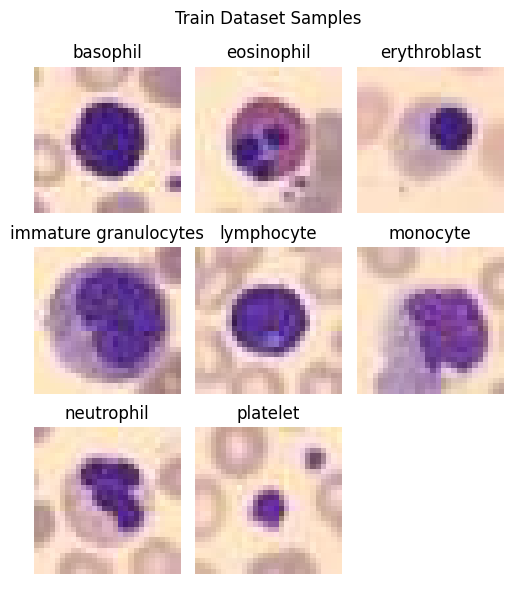

In [13]:
images = []
for i in range(len(labels)):
    images.append(X_train[y_train==i][0])

image_panel = create_image_panel(images, labels, title="Train Dataset Samples")
plt.show(image_panel)

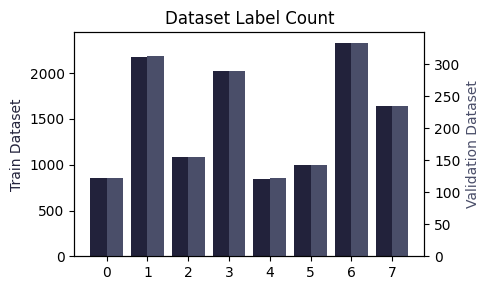

In [14]:
label_count_train = [sum(y_train==i) for i in range(len(labels))]
label_count_val = [sum(y_val==i) for i in range(len(labels))]
create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset",
    values2=label_count_val,
    axis2_label="Validation Dataset",
    title="Dataset Label Count",
)
plt.show()

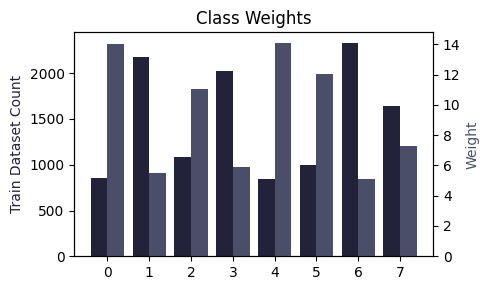

In [15]:
class_weight = {i:1 / sum(y_train==i) * len(y_train) for i in range(len(labels))}

create_bar_plot(
    labels=range(len(labels)),
    values=label_count_train,
    axis_label="Train Dataset Count",
    values2=class_weight.values(),
    axis2_label="Weight",
    title="Class Weights",
)
plt.show()

## MLP

In [16]:
from tensorflow import keras
import tensorflow as tf

In [49]:
def make_mlp(nodes=100, learning_rate=1e-3, use_augmentation=False):

    input_ = keras.models.Sequential([
        keras.layers.Input(shape=(image_size,image_size,3))
    ])

    data_augmentation = keras.models.Sequential([
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(height_factor=(-0.3, -0.1)),
    ])

    mlp = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(nodes, activation="relu"),
        keras.layers.Dense(len(labels), activation="softmax")
    ])

    if data_augmentation:
        model = keras.models.Sequential([
            input_,
            data_augmentation,
            mlp
        ])
    else:
        model = keras.models.Sequential([
            input_,
            mlp
        ])

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc")])

    return model

In [60]:
mlp_models["Vanilla"].summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_28 (Sequential)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 8)              │       708,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,124,926 (8.11 MB)

 Trainable params: 708,308 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,416,618 (5.40 MB)

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pt-br

In [50]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        start_from_epoch=10,
        mode='min',
        restore_best_weights=True
    ),
]

In [51]:
def make_and_train_mlp(options_dict):
    default_ = {
        'nodes': 100,
        'learning_rate': 1E-3,
        'use_augmentation': False,
        'epochs': 10,
        'batch_size': 32,
        'class_weight': None
    }
    for k,v in default_.items():
        if k not in options_dict:
            options_dict[k] = v
    model = make_mlp(
        nodes=options_dict['nodes'],
        learning_rate=options_dict['learning_rate'],
        use_augmentation=options_dict['use_augmentation'])
    model.fit(
        X_train,
        y_train,
        epochs=options_dict['epochs'],
        batch_size=options_dict['batch_size'],
        validation_data = (X_val, y_val),
        class_weight=options_dict['class_weight'],
        callbacks=callbacks)
    return model

In [52]:
mlp_models = {}
mlp_options_vanilla = {
    'nodes': 300,
    'learning_rate': 1E-4,
    'use_augmentation': False,
    'epochs': 1000,
    'batch_size': 32,
    'class_weight': None}
mlp_models['Vanilla'] = make_and_train_mlp(mlp_options_vanilla)

Epoch 1/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - acc: 0.4000 - loss: 1.6103 - val_acc: 0.4054 - val_loss: 1.6286
Epoch 2/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.6111 - loss: 1.1192 - val_acc: 0.4825 - val_loss: 1.4785
Epoch 3/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - acc: 0.6534 - loss: 0.9898 - val_acc: 0.4445 - val_loss: 1.6173
Epoch 4/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.6714 - loss: 0.9341 - val_acc: 0.3925 - val_loss: 1.7530
Epoch 5/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.6900 - loss: 0.9001 - val_acc: 0.4661 - val_loss: 1.4490
Epoch 6/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - acc: 0.7119 - loss: 0.8546 - val_acc: 0.5029 - val_loss: 1.3412
Epoch 7/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.7204 - loss: 0.8254 - val_acc: 0.4848 - val_loss: 1.5134
Epoch 8/1000
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.7252 - loss: 0.7979 - val_acc: 0.5549 - val_loss: 1.2409
Epoch 9/1000
374/374 ━━━━━━━━━━━

In [ ]:
mlp_models['Vanilla'].pre

In [44]:
def update_dict(ref_dict, new_dict):
  updated_dict = ref_dict.copy()
  updated_dict.update({key: value for key, value in new_dict.items() if key in ref_dict})
  return updated_dict

In [ ]:
mlp_tests = {}
mlp_tests['With augmentation'] = update_dict(mlp_options_vanilla,
                                             {'use_augmentation': True})
mlp_tests['With class weight'] = update_dict(mlp_options_vanilla,
                                             {'class_weight': class_weight})
mlp_tests['With weight+augm.'] = update_dict(mlp_options_vanilla,
                                             {'use_augmentation': True,
                                              'class_weight': class_weight})

In [35]:
for k, v in mlp_tests.items():
    print(f'############## {k} ##############')
    mlp_models[k] = make_and_train_mlp(v)

############## Vanilla ##############
Epoch 1/100
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - acc: 0.4334 - loss: 1.5351 - val_acc: 0.3511 - val_loss: 1.6843
Epoch 2/100
249/374 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - acc: 0.6207 - loss: 1.0624

KeyboardInterrupt: 

In [30]:
def plot_metrics(history):
    metrics = ['acc', 'loss']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[2],
            label='Train')
        plt.plot(
            history.epoch,
            history.history['val_'+metric],
            color=colors[3],
            label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()


In [ ]:
def plot_metrics_comparison(model_dict):
    metrics = ['acc', 'loss']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[2],
            label='Train')
        plt.plot(
            history.epoch,
            history.history['val_'+metric],
            color=colors[3],
            label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()


In [42]:
mlp_models['Vanilla'].history.params

{'verbose': 'auto', 'epochs': 1000, 'steps': 374}

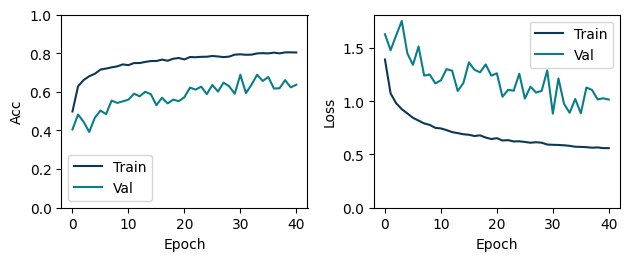

In [53]:
plot_metrics(mlp_models['Vanilla'].history)

In [43]:
model_summary(mlp_models['Vanilla'], X_test, y_test, labels, "Vanilla MLP", "vanilla_mlp.png")

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

## Simple CNN

## Deep CNN